In [1]:
import gym
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

In [2]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


Benefits of Using RBF Coder in CartPole
Generalization: RBF encoding helps the learning algorithm generalize from seen states to unseen states by providing a smoother representation of the state space.
Dimensionality Reduction: It can reduce the effective dimensionality of the problem when the number of RBF centers is less than the dimensionality of the raw state space.
Non-Linearity: It allows linear models to capture non-linear relationships, which is crucial for solving problems like CartPole where the relationship between state variables and optimal actions is highly non-linear.

In [25]:
class RBFCoder:
    def __init__(self, num_rbf, num_of_samples, state_space_low, state_space_high, samples=None, initialization='random'):
        self.num_rbf = num_rbf
        self.num_of_samples = num_of_samples
        self.state_space_low = state_space_low
        self.state_space_high = state_space_high
        # Choose the initialization method based on the parameter
        if initialization == 'random':
            self.samples = samples if samples is not None else self.random_samples()
        elif initialization == 'grid':
            self.samples = self.grid_samples()
        else:
            raise ValueError("Unsupported initialization method.")
        self.centers = self.initialize_centers()

    def random_samples(self):
        """Generate random samples within the state space bounds."""
        return np.random.uniform(self.state_space_low, self.state_space_high, (self.num_of_samples, len(self.state_space_low)))

    def grid_samples(self):
        """Generate samples on a regular grid within the state space bounds."""
        dimensions = len(self.state_space_low)
        # Ensure we generate at least as many samples as requested
        points_per_dim = int(round(self.num_of_samples ** (1 / dimensions)))
        # Generate grid points for each dimension
        axes = [np.linspace(self.state_space_low[i], self.state_space_high[i], points_per_dim) for i in range(dimensions)]
        # Create a meshgrid and reshape it into a list of points
        grid = np.meshgrid(*axes)
        grid_points = np.vstack([axis.flatten() for axis in grid]).T
        return grid_points[:self.num_of_samples]  # Ensure only the requested number of samples is returned

    def initialize_centers(self):
        """Initialize RBF centers using K-Means++ if there are more samples than RBFs."""
        if len(self.samples) >= self.num_rbf:
            kmeans = KMeans(n_clusters=self.num_rbf, init='k-means++', random_state=0).fit(self.samples)
            return kmeans.cluster_centers_
        else:
            return self.samples  # Directly use the samples if their number matches the number of RBFs

    def encode(self, state):
        """Encode the given state using the RBF kernels."""
        distances = np.linalg.norm(state - self.centers, axis=1)
        phi = np.exp(-0.5 * distances**2)
        return phi

In [26]:
class ExpectedSarsaAgent:
    def __init__(self, coder, num_actions, alpha, gamma, epsilon):
        self.coder = coder
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.random.uniform(-0.001, 0.001, (self.coder.num_rbf, num_actions))

    def select_action(self, state):
        encoded_state = self.coder.encode(state)
        q_values = np.dot(encoded_state, self.weights)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state, done):
        current_encoded_state = self.coder.encode(state)
        next_encoded_state = self.coder.encode(next_state)
        current_q = np.dot(current_encoded_state, self.weights[:, action])

        next_q_values = np.dot(next_encoded_state, self.weights)
        expected_next_q = np.sum(next_q_values * self.get_action_probabilities(next_q_values)) if not done else 0

        td_error = reward + self.gamma * expected_next_q - current_q
        self.weights[:, action] += self.alpha * td_error * current_encoded_state

    def get_action_probabilities(self, q_values):
        action_probabilities = np.ones(self.num_actions) * self.epsilon / self.num_actions
        best_action = np.argmax(q_values)
        action_probabilities[best_action] += (1.0 - self.epsilon)
        return action_probabilities

## Testing

In [27]:
def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')


def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None


def run_episode(env, agent):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Select the current action
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)

        # Update the Q-value for Q-learning
        agent.update(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

    return total_reward

In [28]:
def plot_rewards(rewards_data, algorithm_name="Q learning"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

def plot_rewards_epsilon(rewards_data, algorithm_name="Q learning"):

    for epsilon, alphas in rewards_data.items():
        plt.figure(figsize=(14, 7))
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

        plt.title(f'Average Performance and IQR by Alpha ({algorithm_name} ε={epsilon})')
        plt.xlabel('Episodes')
        plt.ylabel('Average Reward')
        plt.legend()
        plt.show()

In [50]:
def train_agent(env, coder, Algorithm, run_episode, save_file, epsilons, alphas, gamma, num_runs=50, num_episodes=1000):
    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in alphas} for epsilon in epsilons}

    # Loop over epsilon and alpha combinations
    for epsilon in epsilons:
        for alpha in alphas:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):
                print(f"Run {run + 1}/{num_runs}")
                # Initialize the agent with current epsilon and alpha
                agent = Algorithm(alpha=alpha, epsilon=epsilon, num_actions=env.action_space.n, coder=coder, gamma=gamma)

                episode_rewards = []  # Collect rewards for each episode in the current run
                for episode in range(num_episodes):
                    reward = run_episode(env, agent)
                    episode_rewards.append(reward)

                    # if (episode + 1) % 100 == 0:
                    print(f'Episode {episode + 1}: total reward = {reward}')

                run_rewards.append(episode_rewards)

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards
            print(f"Finished training with epsilon: {epsilon}, alpha: {alpha}")

    plot_rewards(rewards_data)

    if not(save_file == ""):
      save_rewards_data(rewards_data, save_file)

    return rewards_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Experiment

In [43]:
# Create CartPole environment
env = gym.make('CartPole-v1')

# Define RBF parameters
num_rbf = 1000
state_space_low = [-2.4, -10.0, -0.42, -10.0]  # Cart position, Cart velocity, Pole angle, Pole velocity at tip
state_space_high = [2.4, 10.0, 0.42, 10.0]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training with epsilon: 0.1, alpha: 0.1
Run 1/3
Episode 1: total reward = 11.0
Episode 2: total reward = 10.0
Episode 3: total reward = 10.0
Episode 4: total reward = 10.0
Episode 5: total reward = 10.0
Episode 6: total reward = 10.0
Episode 7: total reward = 10.0
Episode 8: total reward = 9.0
Episode 9: total reward = 8.0
Episode 10: total reward = 9.0
Episode 11: total reward = 9.0
Episode 12: total reward = 9.0
Episode 13: total reward = 10.0
Episode 14: total reward = 9.0
Episode 15: total reward = 11.0
Episode 16: total reward = 9.0
Episode 17: total reward = 10.0
Episode 18: total reward = 10.0
Episode 19: total reward = 10.0
Episode 20: total reward = 13.0
Episode 21: total reward = 13.0
Episode 22: total reward = 11.0
Episode 23: total reward = 9.0
Episode 24: total reward = 10.0
Episode 25: total reward = 11.0
Episode 26: total reward = 16.0
Episode 27: total reward = 11.0
Episode 28: total reward = 8.0
Episode 29: total reward = 9.0
Episode 30: total reward = 8.0
Episode 31: t

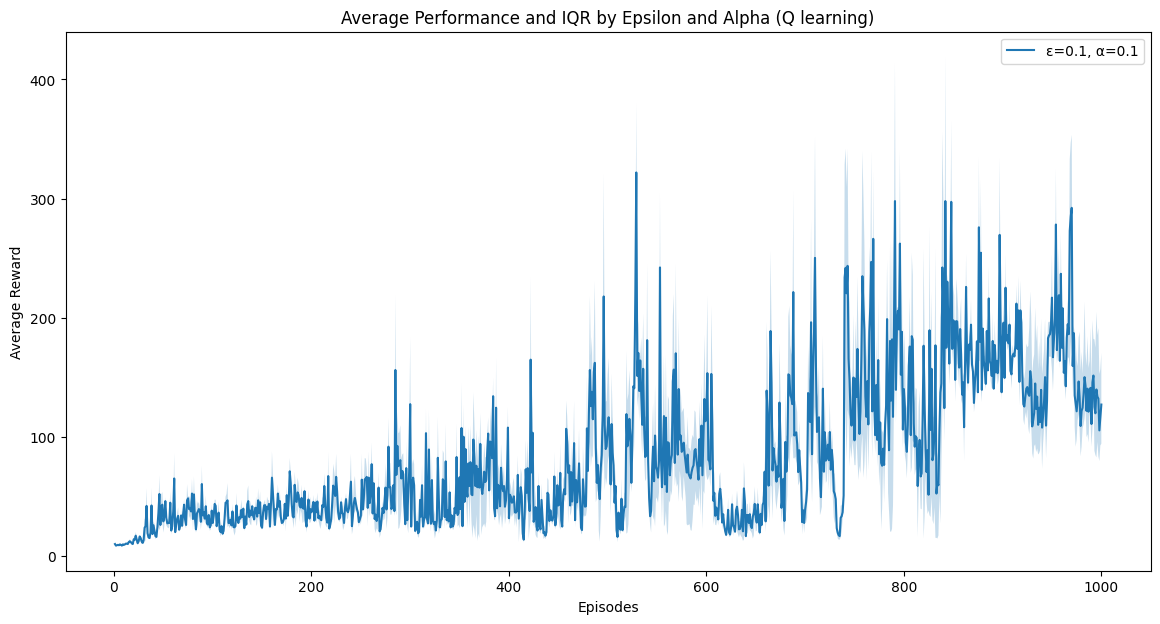

In [51]:
# Create RBF coder
rbf_coder = RBFCoder(num_rbf, state_space_low, state_space_high)

# Initialize Expected SARSA agent
num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=3,
    num_episodes=1000
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training with epsilon: 0.1, alpha: 0.1
Run 1/3
Episode 1: total reward = 12.0
Episode 2: total reward = 8.0
Episode 3: total reward = 10.0
Episode 4: total reward = 9.0
Episode 5: total reward = 10.0
Episode 6: total reward = 11.0
Episode 7: total reward = 10.0
Episode 8: total reward = 10.0
Episode 9: total reward = 9.0
Episode 10: total reward = 10.0
Episode 11: total reward = 10.0
Episode 12: total reward = 11.0
Episode 13: total reward = 9.0
Episode 14: total reward = 10.0
Episode 15: total reward = 10.0
Episode 16: total reward = 13.0
Episode 17: total reward = 12.0
Episode 18: total reward = 10.0
Episode 19: total reward = 10.0
Episode 20: total reward = 13.0
Episode 21: total reward = 15.0
Episode 22: total reward = 11.0
Episode 23: total reward = 17.0
Episode 24: total reward = 14.0
Episode 25: total reward = 15.0
Episode 26: total reward = 13.0
Episode 27: total reward = 12.0
Episode 28: total reward = 12.0
Episode 29: total reward = 13.0
Episode 30: total reward = 13.0
Episod

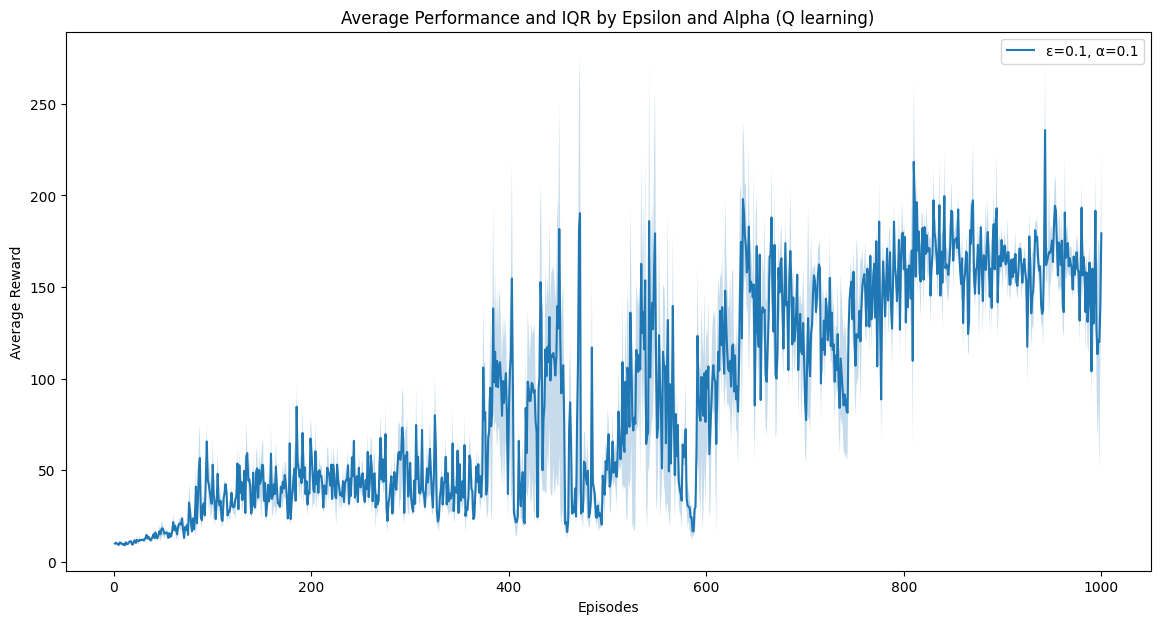

In [52]:
# Create RBF coder
rbf_coder = RBFCoder(num_rbf, state_space_low, state_space_high)

# Initialize Expected SARSA agent
num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=3,
    num_episodes=1000
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training with epsilon: 0.1, alpha: 0.1
Run 1/3
Episode 1: total reward = 10.0
Episode 2: total reward = 10.0
Episode 3: total reward = 11.0
Episode 4: total reward = 11.0
Episode 5: total reward = 10.0
Episode 6: total reward = 9.0
Episode 7: total reward = 10.0
Episode 8: total reward = 9.0
Episode 9: total reward = 10.0
Episode 10: total reward = 9.0
Episode 11: total reward = 12.0
Episode 12: total reward = 10.0
Episode 13: total reward = 10.0
Episode 14: total reward = 9.0
Episode 15: total reward = 8.0
Episode 16: total reward = 9.0
Episode 17: total reward = 8.0
Episode 18: total reward = 11.0
Episode 19: total reward = 10.0
Episode 20: total reward = 9.0
Episode 21: total reward = 11.0
Episode 22: total reward = 13.0
Episode 23: total reward = 9.0
Episode 24: total reward = 10.0
Episode 25: total reward = 10.0
Episode 26: total reward = 12.0
Episode 27: total reward = 15.0
Episode 28: total reward = 14.0
Episode 29: total reward = 16.0
Episode 30: total reward = 18.0
Episode 31:

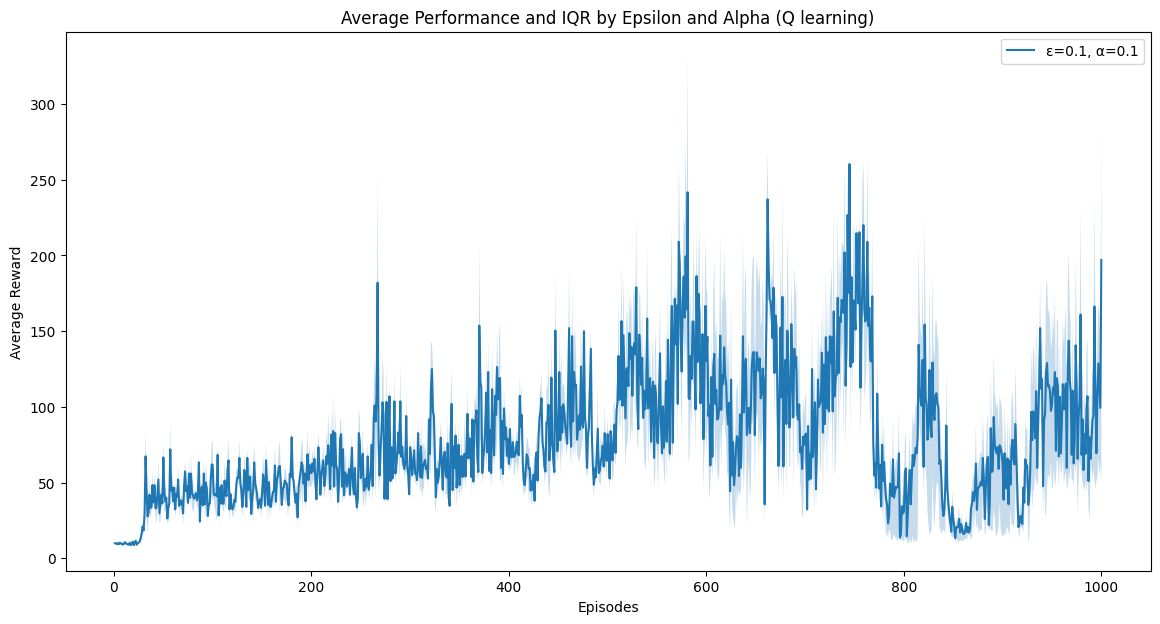

In [53]:
# Create RBF coder
rbf_coder = RBFCoder(num_rbf, state_space_low, state_space_high)

# Initialize Expected SARSA agent
num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=3,
    num_episodes=1000
)

In [111]:
# Create RBF coder
rbf_coder_1 = RBFCoder(2000, 50000, state_space_low, state_space_high, samples=None, initialization='grid')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training with epsilon: 0.1, alpha: 0.1
Run 1/3
Episode 1: total reward = 9.0
Episode 2: total reward = 10.0
Episode 3: total reward = 10.0
Episode 4: total reward = 8.0
Episode 5: total reward = 10.0
Episode 6: total reward = 12.0
Episode 7: total reward = 10.0
Episode 8: total reward = 8.0
Episode 9: total reward = 8.0
Episode 10: total reward = 10.0
Episode 11: total reward = 10.0
Episode 12: total reward = 8.0
Episode 13: total reward = 9.0
Episode 14: total reward = 22.0
Episode 15: total reward = 28.0
Episode 16: total reward = 23.0
Episode 17: total reward = 14.0
Episode 18: total reward = 36.0
Episode 19: total reward = 30.0
Episode 20: total reward = 50.0
Episode 21: total reward = 59.0
Episode 22: total reward = 41.0
Episode 23: total reward = 31.0
Episode 24: total reward = 25.0
Episode 25: total reward = 20.0
Episode 26: total reward = 14.0
Episode 27: total reward = 14.0
Episode 28: total reward = 71.0
Episode 29: total reward = 19.0
Episode 30: total reward = 27.0
Episode 

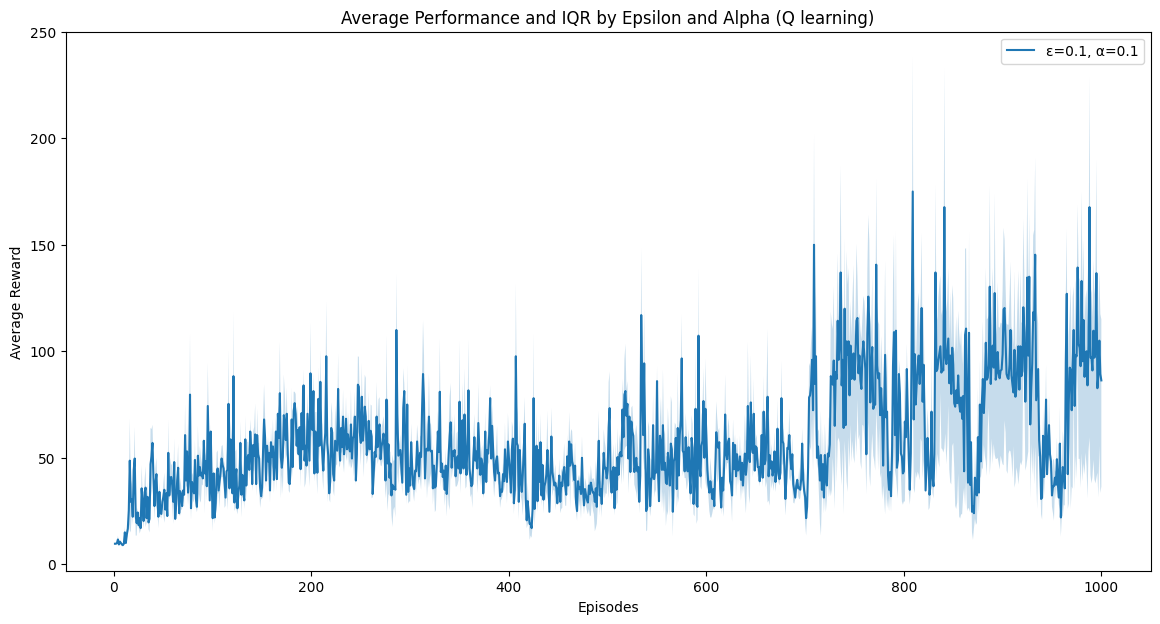

In [112]:
# Create RBF coder
# rbf_coder = RBFCoder(20000, state_space_low, state_space_high, samples=None, initialization='grid')

# Initialize Expected SARSA agent
num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder_1,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=3,
    num_episodes=1000
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training with epsilon: 0.1, alpha: 0.1
Run 1/3
Episode 1: total reward = 9.0
Episode 2: total reward = 9.0
Episode 3: total reward = 9.0
Episode 4: total reward = 10.0
Episode 5: total reward = 8.0
Episode 6: total reward = 9.0
Episode 7: total reward = 8.0
Episode 8: total reward = 10.0
Episode 9: total reward = 10.0
Episode 10: total reward = 9.0
Episode 11: total reward = 11.0
Episode 12: total reward = 8.0
Episode 13: total reward = 10.0
Episode 14: total reward = 31.0
Episode 15: total reward = 11.0
Episode 16: total reward = 13.0
Episode 17: total reward = 14.0
Episode 18: total reward = 12.0
Episode 19: total reward = 13.0
Episode 20: total reward = 9.0
Episode 21: total reward = 14.0
Episode 22: total reward = 12.0
Episode 23: total reward = 11.0
Episode 24: total reward = 39.0
Episode 25: total reward = 52.0
Episode 26: total reward = 15.0
Episode 27: total reward = 31.0
Episode 28: total reward = 28.0
Episode 29: total reward = 28.0
Episode 30: total reward = 47.0
Episode 31:

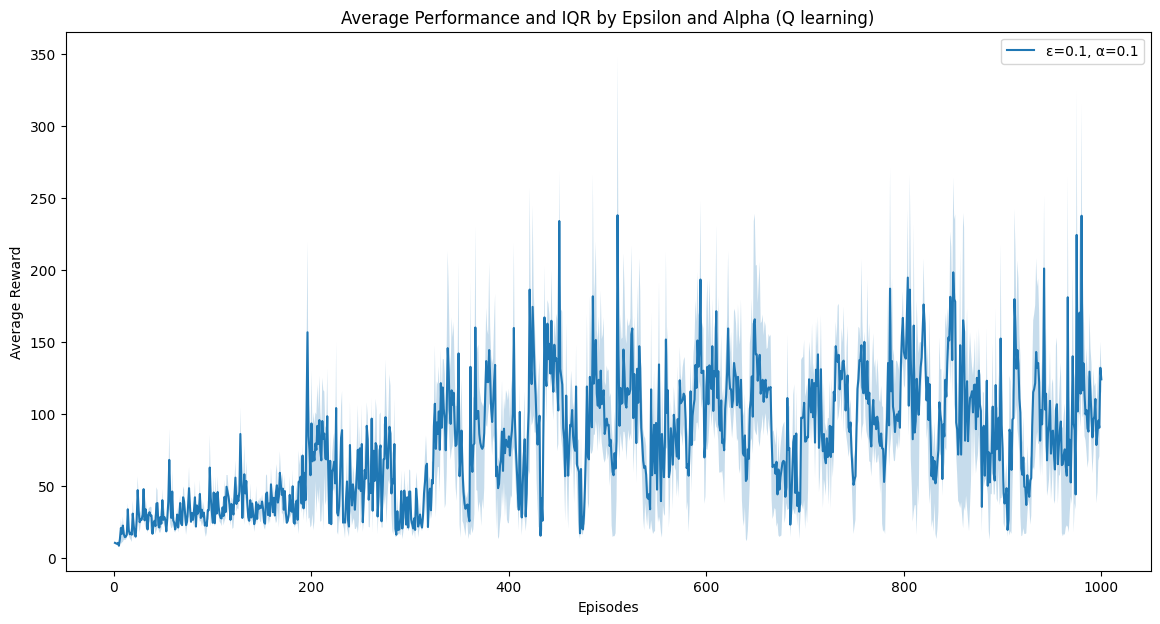

In [113]:
# Create RBF coder
rbf_coder_2 = RBFCoder(2000, 50000, state_space_low, state_space_high, samples=None, initialization='random')

num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder_2,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=3,
    num_episodes=1000
)

串流輸出內容已截斷至最後 5000 行。
Episode 6: total reward = 10.0
Episode 7: total reward = 9.0
Episode 8: total reward = 9.0
Episode 9: total reward = 11.0
Episode 10: total reward = 11.0
Episode 11: total reward = 11.0
Episode 12: total reward = 8.0
Episode 13: total reward = 10.0
Episode 14: total reward = 14.0
Episode 15: total reward = 14.0
Episode 16: total reward = 9.0
Episode 17: total reward = 14.0
Episode 18: total reward = 16.0
Episode 19: total reward = 43.0
Episode 20: total reward = 37.0
Episode 21: total reward = 55.0
Episode 22: total reward = 48.0
Episode 23: total reward = 62.0
Episode 24: total reward = 16.0
Episode 25: total reward = 15.0
Episode 26: total reward = 20.0
Episode 27: total reward = 21.0
Episode 28: total reward = 27.0
Episode 29: total reward = 18.0
Episode 30: total reward = 16.0
Episode 31: total reward = 15.0
Episode 32: total reward = 22.0
Episode 33: total reward = 18.0
Episode 34: total reward = 20.0
Episode 35: total reward = 44.0
Episode 36: total reward = 

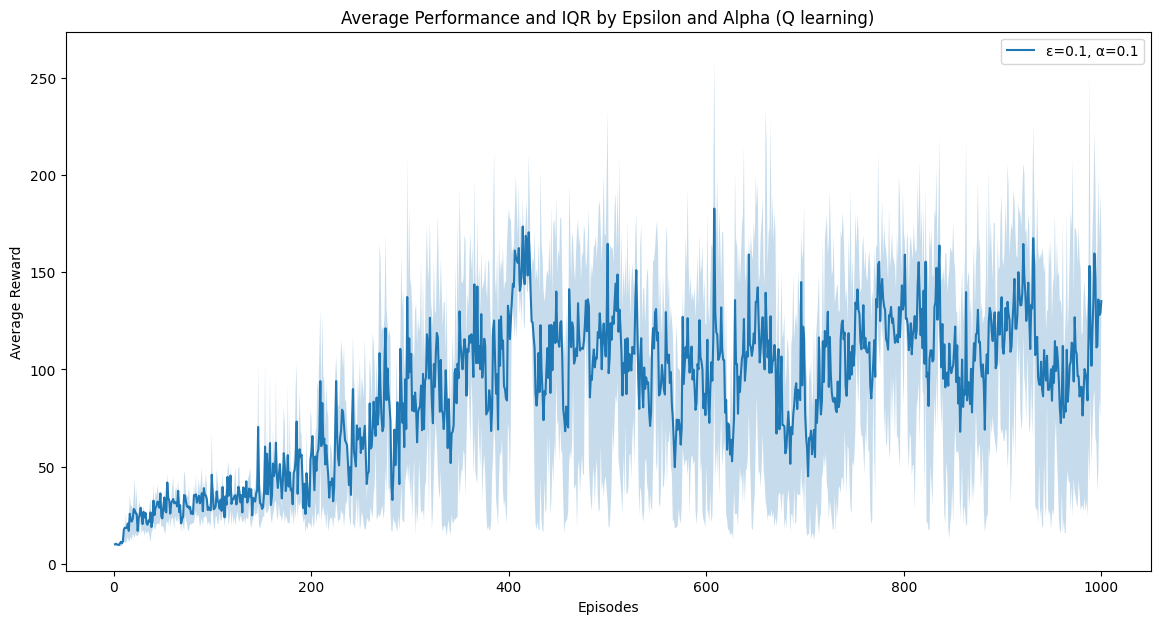

In [114]:
num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder_2,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=10,
    num_episodes=1000
)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


串流輸出內容已截斷至最後 5000 行。
Episode 6: total reward = 9.0
Episode 7: total reward = 8.0
Episode 8: total reward = 9.0
Episode 9: total reward = 14.0
Episode 10: total reward = 10.0
Episode 11: total reward = 9.0
Episode 12: total reward = 10.0
Episode 13: total reward = 14.0
Episode 14: total reward = 9.0
Episode 15: total reward = 13.0
Episode 16: total reward = 12.0
Episode 17: total reward = 13.0
Episode 18: total reward = 29.0
Episode 19: total reward = 23.0
Episode 20: total reward = 14.0
Episode 21: total reward = 107.0
Episode 22: total reward = 22.0
Episode 23: total reward = 52.0
Episode 24: total reward = 33.0
Episode 25: total reward = 58.0
Episode 26: total reward = 63.0
Episode 27: total reward = 33.0
Episode 28: total reward = 85.0
Episode 29: total reward = 96.0
Episode 30: total reward = 23.0
Episode 31: total reward = 22.0
Episode 32: total reward = 32.0
Episode 33: total reward = 19.0
Episode 34: total reward = 16.0
Episode 35: total reward = 25.0
Episode 36: total reward = 

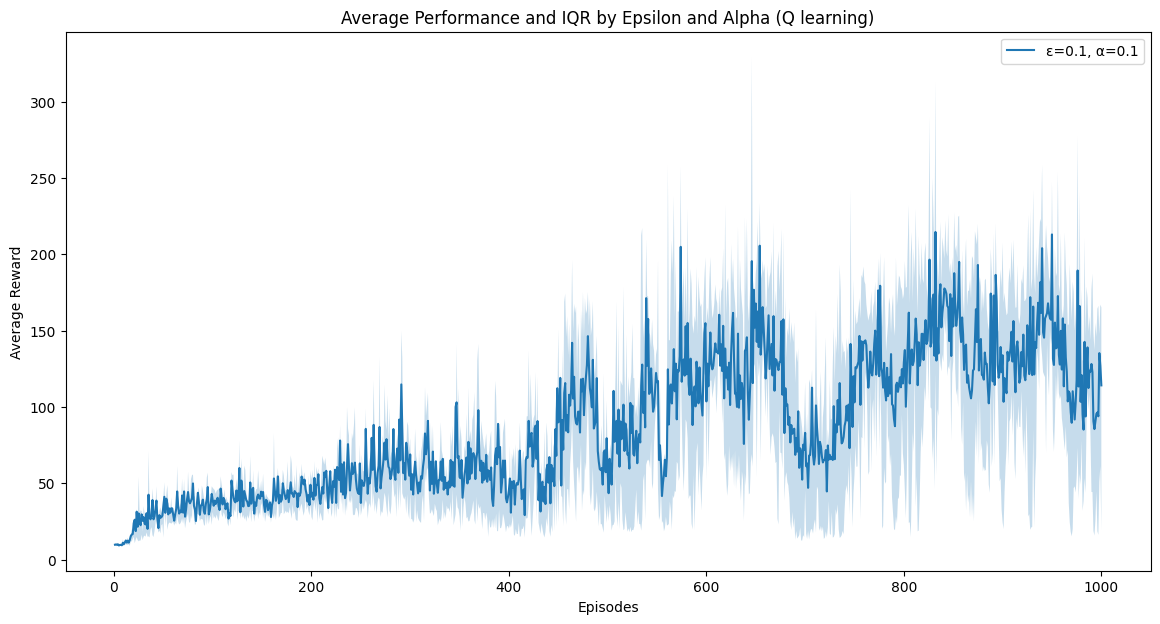

In [115]:
# Create RBF coder
rbf_coder_5 = RBFCoder(1000, 60000, state_space_low, state_space_high, samples=None, initialization='random')

num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder_5,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=8,
    num_episodes=1000
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


串流輸出內容已截斷至最後 5000 行。
Episode 6: total reward = 8.0
Episode 7: total reward = 8.0
Episode 8: total reward = 14.0
Episode 9: total reward = 9.0
Episode 10: total reward = 9.0
Episode 11: total reward = 13.0
Episode 12: total reward = 23.0
Episode 13: total reward = 16.0
Episode 14: total reward = 15.0
Episode 15: total reward = 13.0
Episode 16: total reward = 25.0
Episode 17: total reward = 17.0
Episode 18: total reward = 14.0
Episode 19: total reward = 14.0
Episode 20: total reward = 11.0
Episode 21: total reward = 13.0
Episode 22: total reward = 22.0
Episode 23: total reward = 18.0
Episode 24: total reward = 32.0
Episode 25: total reward = 21.0
Episode 26: total reward = 100.0
Episode 27: total reward = 48.0
Episode 28: total reward = 62.0
Episode 29: total reward = 48.0
Episode 30: total reward = 34.0
Episode 31: total reward = 21.0
Episode 32: total reward = 14.0
Episode 33: total reward = 20.0
Episode 34: total reward = 16.0
Episode 35: total reward = 17.0
Episode 36: total reward =

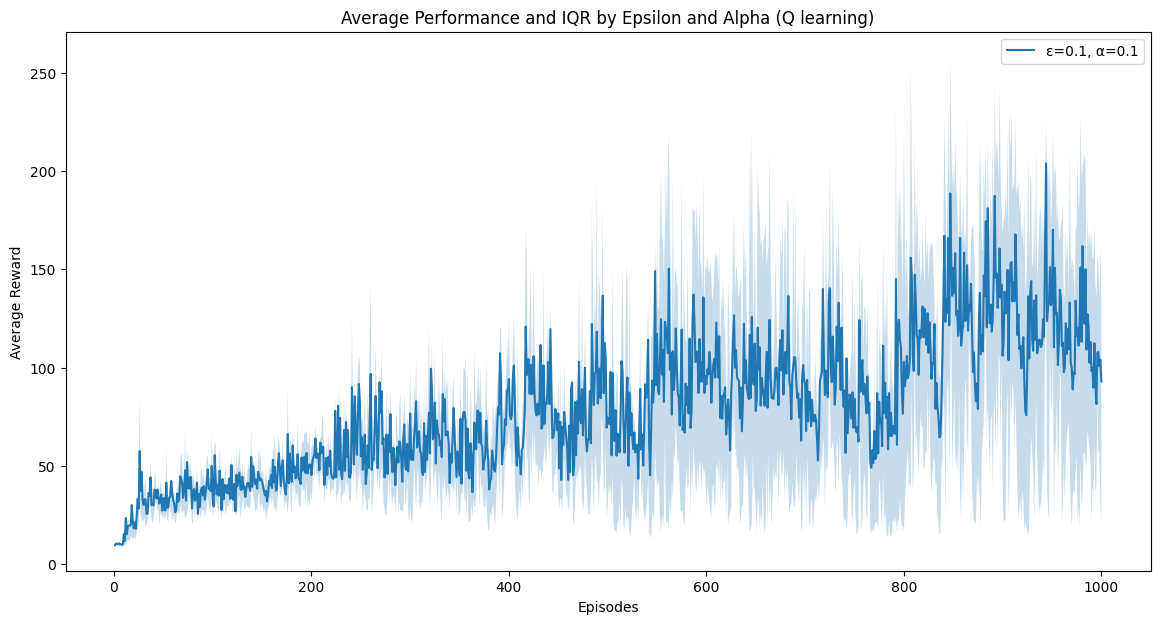

In [116]:
# Create RBF coder
rbf_coder_7 = RBFCoder(500, 60000, state_space_low, state_space_high, samples=None, initialization='random')

num_actions = env.action_space.n

rewards = train_agent(
    env=env,
    coder=rbf_coder_5,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="",
    epsilons=[0.1],
    alphas=[0.1],
    gamma=0.99,
    num_runs=8,
    num_episodes=1000
)

In [118]:
rbf_coder_2.centers.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2000, 4)

串流輸出內容已截斷至最後 5000 行。
Episode 6: total reward = 27.0
Episode 7: total reward = 14.0
Episode 8: total reward = 18.0
Episode 9: total reward = 14.0
Episode 10: total reward = 54.0
Episode 11: total reward = 40.0
Episode 12: total reward = 21.0
Episode 13: total reward = 19.0
Episode 14: total reward = 25.0
Episode 15: total reward = 15.0
Episode 16: total reward = 51.0
Episode 17: total reward = 34.0
Episode 18: total reward = 14.0
Episode 19: total reward = 15.0
Episode 20: total reward = 23.0
Episode 21: total reward = 24.0
Episode 22: total reward = 35.0
Episode 23: total reward = 17.0
Episode 24: total reward = 51.0
Episode 25: total reward = 29.0
Episode 26: total reward = 16.0
Episode 27: total reward = 16.0
Episode 28: total reward = 18.0
Episode 29: total reward = 19.0
Episode 30: total reward = 23.0
Episode 31: total reward = 43.0
Episode 32: total reward = 42.0
Episode 33: total reward = 30.0
Episode 34: total reward = 25.0
Episode 35: total reward = 59.0
Episode 36: total rewar

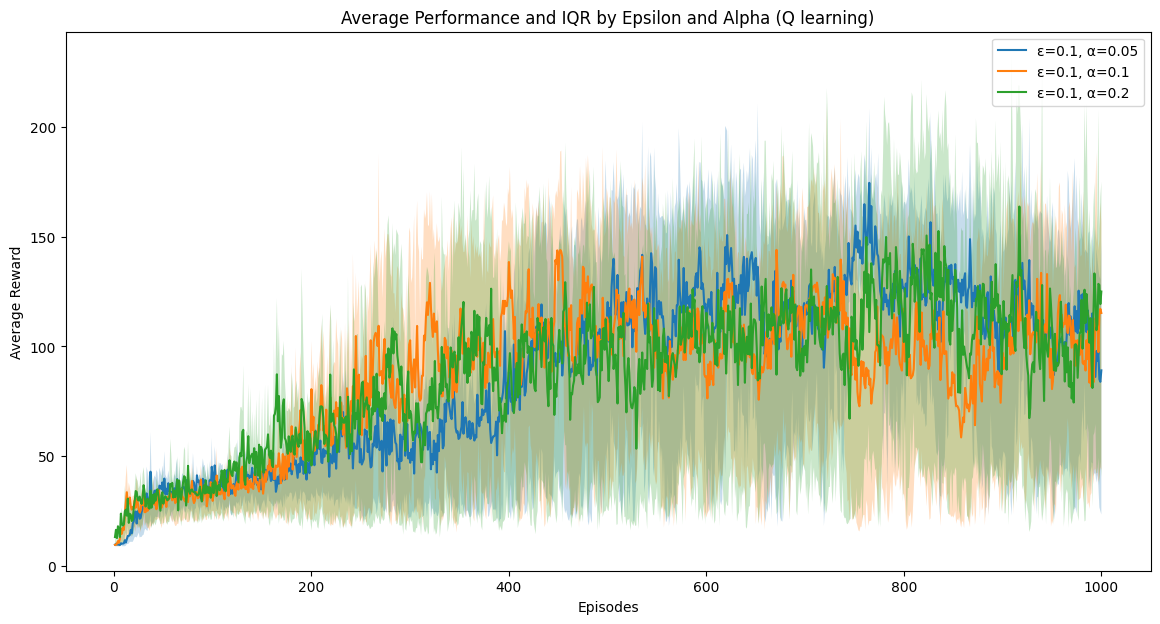

Rewards data saved to /content/drive/MyDrive/COMP 579 RL Project/ES_1


In [121]:
rewards = train_agent(
    env=env,
    coder=rbf_coder_2,
    Algorithm=ExpectedSarsaAgent,
    run_episode=run_episode,
    save_file="/content/drive/MyDrive/COMP 579 RL Project/ES_1",
    epsilons=[0.1],
    alphas=[0.05, 0.1, 0.2],
    gamma=0.99,
    num_runs=30,
    num_episodes=1000
)